# Import Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from warnings import filterwarnings
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, StratifiedKFold, train_test_split

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
## Yanlin's path to import dataset - df = pd.read_csv("/content/drive/MyDrive/Bluelabs-practicum/Copy of columbia_qmss_survey_ids_hashed000 (2)")
#df = pd.read_csv("/content/drive/MyDrive/columbia_qmss_survey_ids_hashed000.csv")
df = pd.read_csv("/content/drive/MyDrive/survey_data.csv")
groups = pd.read_csv('/content/drive/My Drive/party_primary_drafts_v3.csv') #taken from presidential team folder
print(df.shape)

(41306, 110)


In [ ]:
# 1- Dem, 2 - Rep, 3 - Other, 4 - other, 5 - other, NA - NA
#drop rows where there is no "result" to predict
data = df[(df["support_gov"] == 1) | (df["support_gov"] == 2)]
print(data.shape)
# 1- Dem, 2 - Rep
data.groupby("support_gov").size()

(8019, 110)


support_gov
1.0    4171
2.0    3848
dtype: int64

In [ ]:
missing_details = pd.DataFrame(data.isnull().mean(),columns=['Missing'])#.reset_index(inplace=True)
missing_details = missing_details.reset_index().rename(columns={'index': 'Var'})

remove_cols = list(missing_details[missing_details['Missing'] > 0].sort_values(by='Missing',ascending=False)['Var'])

In [ ]:
remove_cols2 = [col for col in data.columns if len(data[col].value_counts()) <= 1]
remove_cols = list(set(remove_cols + remove_cols2))


In [ ]:
df = data.copy()
for col in df.columns:
    if col in remove_cols:
        del df[col]
print(df.shape)
df.head()

(8019, 91)


,Unnamed: 0,bInner Ring,cOuter Ring,dRural,Income 030k-50k,Income 050k-75k,Income 075k-125k,Income 125k+,Unnamed: 0.1,support_gov,age_a22to29,age_b30to39,age_c40to49,age_d50to59,age_e60to69,age_f70to79,age_g80plus,gender_male,black,hispanic,asian,other_ethnicity,single,children,children_3plus,homeowner,renter,bach_degree_modeled,post_grad_modeled,inactive_voter,absentee_voter,early_voter,non_primary_voter,midterm_primary_ever,dem_primary_voter,dem_primary_only,rep_primary_voter,rep_primary_only,dem_primary_mr,rep_primary_mr,switch_primary_voter,switch_primary_dem_mr,switch_primary_rep_mr,midterm_voter,presidential_voter,new_registrant,non_voter,hh_black_u,hh_hispanic_u,hh_asian_u,hh_conservative_donor_u,hh_liberal_donor_u,hasreligion,catholic,christian,bible_reader,donrever_1,liberal_donor,conservative_donor,contbrel_1,contbpol_1,contbhlt_1,blue_collar,farmer,professional_technical,retired,apparel_1,bookmusc_1,electrnc_1,environm_1,outdgrdn_1,outdoor_1,guns_1,golf_1,veteran_1,expensive_items_1,cnty_pct_religious,evan_0to70,evan_100to140,evan_140to230,evan_230plus,vote_pp2012_not_2008,vote_pp2008_not_2012,vote_g2012_or_g2008,vote_g2010_not_2006,vote_g2006_not_2010,vote_pp_or_p2012,vote_pp_or_p2008,greatest_year_d,greatest_year_r,ineligible_2008to2022
27349,28000,0,0,1,0,0,0,1,28001,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.383660,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020.0,1
27350,28001,0,1,0,0,0,0,1,28002,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.388360,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2020.0,0.0,0
27351,28002,0,0,1,0,0,1,0,28003,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.378120,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
27352,28003,1,0,0,1,0,0,0,28004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.509459,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020.0,0.0,1
27353,28004,0,0,0,0,0,1,0,28005,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.312259,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [ ]:
X = df.drop('support_gov', axis=1)
y = df['support_gov']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train.fillna(0))

StandardScaler()

In [ ]:
X_train.shape, X_test.shape, y_train.shape

((6014, 90), (2005, 90), (6014,))

In [ ]:
# Feature Selection
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

sel_ = SelectFromModel(LogisticRegression(C=1, penalty='l2', solver='saga'))
sel_.fit(scaler.transform(X_train.fillna(0)), y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


SelectFromModel(estimator=LogisticRegression(C=1, solver='saga'))

In [ ]:
selected_feat = X_train.columns[(sel_.get_support())]
print('total features: {}'.format((X_train.shape[1])))
print('selected features: {}'.format(len(selected_feat)))
print('features with coefficients shrank to zero: {}'.format(
      np.sum(sel_.estimator_.coef_ == 0)))

total features: 90
selected features: 27
features with coefficients shrank to zero: 0


In [ ]:
selected_feat

Index(['cOuter Ring', 'dRural', 'age_d50to59', 'age_e60to69', 'age_f70to79',
       'gender_male', 'black', 'asian', 'other_ethnicity', 'single',
       'absentee_voter', 'midterm_primary_ever', 'dem_primary_only',
       'rep_primary_voter', 'rep_primary_only', 'dem_primary_mr',
       'rep_primary_mr', 'switch_primary_voter', 'switch_primary_dem_mr',
       'liberal_donor', 'conservative_donor', 'environm_1',
       'vote_pp2008_not_2012', 'vote_g2010_not_2006', 'vote_pp_or_p2012',
       'greatest_year_d', 'greatest_year_r'],
      dtype='object')

In [ ]:
validation_result = pd.read_csv("/content/drive/MyDrive/validation_result.csv")
#validation_result = pd.read_csv('validation_result.csv')

required_cols = ['support_gov']
for a, b, in zip(list(validation_result['Variable']), list(validation_result['Category'])):
  if b != '0.0' and b != '1.0':
    required_cols.append(b)
  else:
    required_cols.append(a)

selected_vars = list(set(required_cols + list(selected_feat)))
selected_vars


['rep_primary_only',
 'switch_primary_dem_mr',
 'hispanic',
 'new_registrant',
 'age_c40to49',
 'dem_primary_voter',
 'age_g80plus',
 'non_voter',
 'presidential_voter',
 'age_b30to39',
 'midterm_voter',
 'early_voter',
 'bach_degree_modeled',
 'black',
 'age_d50to59',
 'absentee_voter',
 'vote_pp2008_not_2012',
 'midterm_primary_ever',
 'asian',
 'dem_primary_only',
 'Income 125k+',
 'age_f70to79',
 'Income 030k-50k',
 'liberal_donor',
 'other_ethnicity',
 'conservative_donor',
 'cOuter Ring',
 'age_e60to69',
 'dem_primary_mr',
 'dRural',
 'Income 075k-125k',
 'vote_g2010_not_2006',
 'post_grad_modeled',
 'single',
 'greatest_year_d',
 'retired',
 'rep_primary_voter',
 'age_a22to29',
 'support_gov',
 'gender_male',
 'rep_primary_mr',
 'bInner Ring',
 'vote_pp_or_p2012',
 'environm_1',
 'greatest_year_r',
 'switch_primary_voter',
 'Income 050k-75k']

In [ ]:
from copy import deepcopy

new_reg = deepcopy(data[selected_vars].drop(columns = ['switch_primary_dem_mr',
                                                       'rep_primary_only',
                                                       'dem_primary_mr',
                                                       'dem_primary_only',
                                                       'switch_primary_voter',
                                                       #'other_ethnicity',
                                                       'dem_primary_voter',
                                                       'rep_primary_voter',
                                                       'midterm_voter',
                                                       'presidential_voter',
                                                       'non_voter',
                                                       'new_registrant'], axis = 1))

X = new_reg.drop('support_gov', axis = 1)
y = new_reg['support_gov'].replace({2.0: 0.0})

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

import statsmodels.api as sm

Xs_train = sm.add_constant(X_train) #adding a constant fits a line for y = mx + b instead of just y = mx
Xs_test = sm.add_constant(X_test)

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
#Logistic SM Regression, fitting on training data
logistic = sm.Logit(y_train, Xs_train)
pd.set_option('display.max_rows', None)
coef = logistic.fit().params
print(coef) #Get coefficients

         Current function value: 0.332679
         Iterations: 35
const                    1.488910
hispanic                 0.557347
age_c40to49             -2.505567
age_g80plus             -2.290973
age_b30to39             -2.423490
early_voter             -0.287042
bach_degree_modeled      0.024252
black                    0.947847
age_d50to59             -2.585777
absentee_voter           1.052353
vote_pp2008_not_2012     0.463918
midterm_primary_ever     0.546034
asian                    1.339937
Income 125k+             0.084383
age_f70to79             -2.457152
Income 030k-50k          0.167886
liberal_donor            3.096376
other_ethnicity         18.808228
conservative_donor      -1.986901
cOuter Ring             -0.539041
age_e60to69             -2.566548
dRural                  -0.763668
Income 075k-125k         0.060809
vote_g2010_not_2006     -0.307675
post_grad_modeled        0.233588
single                   0.446357
greatest_year_d          0.001044
retired         

/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
hey = [str(a) + " * " + str(b) + " + " for a, b, in zip(coef.index, coef)]

j = ""
for i in hey:
  j += i
j

'const * 1.4889102629402076 + hispanic * 0.5573472313654121 + age_c40to49 * -2.5055668799527684 + age_g80plus * -2.2909733948175766 + age_b30to39 * -2.423489910492778 + early_voter * -0.2870415914879248 + bach_degree_modeled * 0.02425156802117327 + black * 0.9478470346822282 + age_d50to59 * -2.585776744207631 + absentee_voter * 1.0523531847266119 + vote_pp2008_not_2012 * 0.4639183997125445 + midterm_primary_ever * 0.5460343061422491 + asian * 1.3399366128113694 + Income 125k+ * 0.08438279554496701 + age_f70to79 * -2.457152092135523 + Income 030k-50k * 0.16788576189411633 + liberal_donor * 3.096376262868315 + other_ethnicity * 18.80822831847005 + conservative_donor * -1.986900813431746 + cOuter Ring * -0.5390411084136834 + age_e60to69 * -2.5665481415720555 + dRural * -0.7636678044572537 + Income 075k-125k * 0.06080946931075712 + vote_g2010_not_2006 * -0.3076750191458758 + post_grad_modeled * 0.2335882271507779 + single * 0.44635740491601705 + greatest_year_d * 0.0010442977715670188 + re

In [ ]:
coef.to_csv('validation_coefficients.csv')

In [ ]:
results = logistic.fit() # Coefficients
results.summary()

         Current function value: 0.332679
         Iterations: 35


/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            support_gov   No. Observations:                 6014
Model:                          Logit   Df Residuals:                     5978
Method:                           MLE   Df Model:                           35
Date:                Wed, 14 Dec 2022   Pseudo R-squ.:                  0.5195
Time:                        20:20:11   Log-Likelihood:                -2000.7
converged:                      False   LL-Null:                       -4163.8
Covariance Type:            nonrobust   LLR p-value:                     0.000
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    1.4889      1.091      1.365      0.172      -0.649       3.627
hispanic                 0.5573      0.275      2.029      0.042       0.019       1.096
age_c40to49             -2.5056      1.083     -2.314      0.021      -4.628      -0.384
age_g80plus             -2.2910      1.096     -2.091      0.037      -4.439      -0.143
age_b30to39             -2.4235      1.083     -2.237      0.025      -4.547      -0.300
early_voter             -0.2870      0.205     -1.402      0.161      -0.688       0.114
bach_degree_modeled      0.0243      0.108      0.224      0.823      -0.188       0.236
black                    0.9478      0.122      7.749      0.000       0.708       1.188
age_d50to59             -2.5858      1.081     -2.391      0.017      -4.705      -0.466
absentee_voter           1.0524      0.103     10.178      0.000       0.850       1.255
vote_pp2008_not_2012     0.4639      0.121      3.826      0.000       0.226       0.702
midterm_primary_ever     0.5460      0.114      4.778      0.000       0.322       0.770
asian                    1.3399      0.355      3.771      0.000       0.644       2.036
Income 125k+             0.0844      0.167      0.504      0.614      -0.244       0.413
age_f70to79             -2.4572      1.084     -2.268      0.023      -4.581      -0.333
Income 030k-50k          0.1679      0.185      0.907      0.364      -0.195       0.531
liberal_donor            3.0964      0.630      4.918      0.000       1.862       4.330
other_ethnicity         18.8082   1516.581      0.012      0.990   -2953.636    2991.253
conservative_donor      -1.9869      0.329     -6.043      0.000      -2.631      -1.342
cOuter Ring             -0.5390      0.139     -3.876      0.000      -0.812      -0.266
age_e60to69             -2.5665      1.082     -2.373      0.018      -4.687      -0.446
dRural                  -0.7637      0.153     -4.986      0.000      -1.064      -0.463
Income 075k-125k         0.0608      0.168      0.363      0.717      -0.268       0.389
vote_g2010_not_2006     -0.3077      0.127     -2.419      0.016      -0.557      -0.058
post_grad_modeled        0.2336      0.112      2.085      0.037       0.014       0.453
single                   0.4464      0.092      4.835      0.000       0.265       0.627
greatest_year_d          0.0010   5.86e-05     17.835      0.000       0.001       0.001
retired                 -0.3378      0.283     -1.195      0.232      -0.892       0.216
age_a22to29             -2.3060      1.096     -2.105      0.035      -4.453      -0.159
gender_male             -0.3638      0.081     -4.512      0.000      -0.522      -0.206
rep_primary_mr          -2.2713      0.153    -14.810      0.000      -2.572      -1.971
bInner Ring             -0.1041      0.137     -0.757      0.449      -0.374       0.165
vote_pp_or_p2012        -0.8110      0.130     -6.228      0.000      -1.066      -0.556
environm_1              -2.9524      

In [ ]:
regcsv = results.summary()
with open('fname.csv','w') as f:
 f.write(regcsv.as_csv())

In [ ]:
from sklearn.metrics import roc_auc_score
logreg = LogisticRegression(random_state = 42).fit(X_train, y_train)
y_preb = logreg.predict(X_test)
y_preb_probs = logreg.predict_proba(X_test)
score = roc_auc_score(y_test, y_preb, average='weighted', multi_class ='ovo')
print(score)

0.867854964297248


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


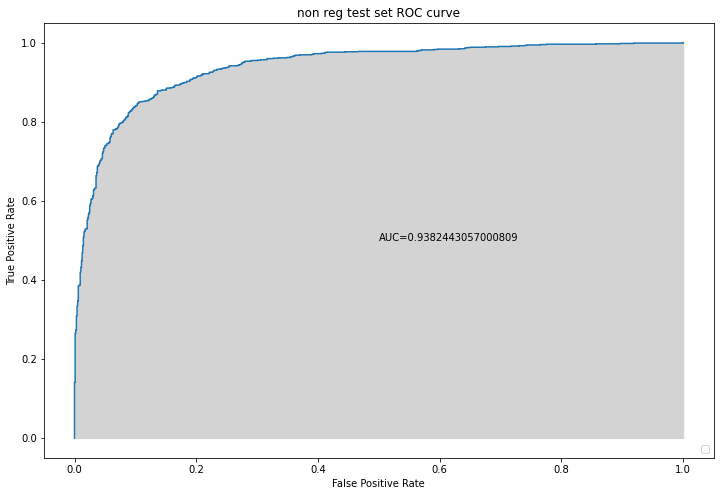

In [ ]:
from sklearn import metrics

y_preb_probs2 = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_preb_probs2)
auc = metrics.roc_auc_score(y_test, y_preb_probs2)

fig, ax = plt.subplots(figsize=(12,8))

plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("non reg test set ROC curve")
plt.legend(loc=4)
plt.fill_between(fpr,tpr,color="lightgrey")
ax.text(0.5,0.5,"AUC="+str(auc))

plt.savefig('ROC_test_set.png')

In [ ]:
test_sample = pd.concat([X_test, y_test], axis = 1)
test_sample['predicted_probability'] = [l[1] for l in list(y_preb_probs)]

test_sample.head(20)

,hispanic,age_c40to49,age_g80plus,age_b30to39,early_voter,bach_degree_modeled,black,age_d50to59,absentee_voter,vote_pp2008_not_2012,midterm_primary_ever,asian,Income 125k+,age_f70to79,Income 030k-50k,liberal_donor,other_ethnicity,conservative_donor,cOuter Ring,age_e60to69,dRural,Income 075k-125k,vote_g2010_not_2006,post_grad_modeled,single,greatest_year_d,retired,age_a22to29,gender_male,rep_primary_mr,bInner Ring,vote_pp_or_p2012,environm_1,greatest_year_r,Income 050k-75k,support_gov,predicted_probability
30709,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1,1.0,0,1.0,0.0,0.0,1,0.0,0,0,0.0,1.0,0.0,2020.0,0.0,0.0,1.0,0.0,0,1.0,1.0,2019.0,0,0.0,0.537174
31095,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0,0.0,1,0.0,0.0,0.0,0,0.0,0,0,1.0,0.0,0.0,2021.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0,1.0,0.940113
32190,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,1.0,0.0,0.0,0,0.0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,1.0,0.0,1,0.0,0.163208
34229,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1,0.0,0,0.0,0.0,0.0,1,0.0,0,0,0.0,1.0,0.0,2020.0,0.0,0.0,0.0,0.0,0,0.0,0.0,2019.0,0,0.0,0.480173
39567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1,1.0,0,0.0,0.0,0.0,0,0.0,0,0,0.0,1.0,0.0,2001.0,0.0,0.0,1.0,1.0,1,1.0,0.0,2020.0,0,0.0,0.115345
38860,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,1.0,0,1.0,0.0,0.0,0,0.0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0.0,1.0,0.0,0,0.0,0.338475
30792,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,1,0.0,0,1,0.0,0.0,1.0,2020.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,1.0,0.955206
31114,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1,0.0,0,1.0,0.0,0.0,0,1.0,0,0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1,1.0,1.0,2018.0,0,0.0,0.017033
40829,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0.0,0,0.0,0.0,0.0,0,1.0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0,0.0,0.0,2018.0,1,0.0,0.003765
31455,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1,0.0,0,0.0,0.0,0.0,0,1.0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,1.0,0.0,2020.0,0,0.0,0.007716


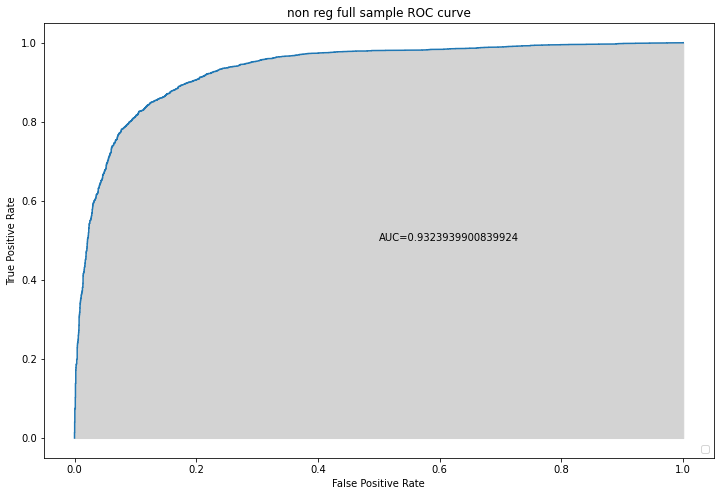

In [ ]:
predicted_probs_full2 = logreg.predict_proba(X)[::,1]
fpr, tpr, _ = metrics.roc_curve(y,  predicted_probs_full2)
auc = metrics.roc_auc_score(y, predicted_probs_full2)


fig, ax = plt.subplots(figsize=(12,8))

plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("non reg full sample ROC curve")
plt.legend(loc=4)
plt.fill_between(fpr,tpr,color="lightgrey")
ax.text(0.5,0.5,"AUC="+str(auc))

plt.savefig('ROC_full_sample.png')

In [ ]:
predicted_probs_full = logreg.predict_proba(X)

full_sample = pd.concat([X, y], axis = 1)
full_sample['predicted_probability'] = [l[1] for l in list(predicted_probs_full)]

full_sample.head(20)

,hispanic,age_c40to49,age_g80plus,age_b30to39,early_voter,bach_degree_modeled,black,age_d50to59,absentee_voter,vote_pp2008_not_2012,midterm_primary_ever,asian,Income 125k+,age_f70to79,Income 030k-50k,liberal_donor,other_ethnicity,conservative_donor,cOuter Ring,age_e60to69,dRural,Income 075k-125k,vote_g2010_not_2006,post_grad_modeled,single,greatest_year_d,retired,age_a22to29,gender_male,rep_primary_mr,bInner Ring,vote_pp_or_p2012,environm_1,greatest_year_r,Income 050k-75k,support_gov,predicted_probability
27349,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1,0.0,0,0.0,0.0,0.0,0,0.0,1,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0,0.0,0.0,2020.0,0,0.0,0.050627
27350,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1,0.0,0,0.0,0.0,0.0,1,0.0,0,0,0.0,0.0,1.0,2020.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,1.0,0.956807
27351,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0,0.0,1,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,1.0,0.486057
27352,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0,0.0,1,0.0,0.0,0.0,0,0.0,0,0,0.0,0.0,0.0,2020.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0,1.0,0.932643
27353,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0,0.0,0,1,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0,0.0,0.0,0.0,0,1.0,0.580109
27354,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,0.0,0,0.0,0.0,0.0,0,0.0,0,0,0.0,0.0,0.0,2020.0,0.0,0.0,1.0,0.0,0,0.0,0.0,0.0,0,1.0,0.889412
27355,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0,0,1.0,0.0,0.0,1,0.0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0,0.0,1.0,0.0,1,1.0,0.225286
27356,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0,0.0,0,0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1,0.0,0.0,0.0,0,1.0,0.550638
27357,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0,0.0,0,0.0,0.0,0.0,1,0.0,0,0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0,1.0,0.0,2020.0,1,0.0,0.014356
27358,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0.0,1,0.0,0.0,0.0,0,0.0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0,1.0,0.475677


# Validation

Generating Predicted and true probability based on the best sample size (2000)

In [ ]:
result = deepcopy(test_sample)

result['age'] = result.filter(regex = 'age').idxmax(axis = 1)
result['ethnicity'] = result[['black', 'hispanic', 'asian','other_ethnicity']].idxmax(axis = 1)
#result['party'] = result[['dem_primary_voter', 'rep_primary_voter']].idxmax(axis = 1)
result['income'] = result[['Income 030k-50k', 'Income 050k-75k', 'Income 075k-125k', 'Income 125k+']].idxmax(axis = 1)
result['education'] = result[['bach_degree_modeled', 'post_grad_modeled']].idxmax(axis = 1)
result['urbanicity'] = result[['dRural','cOuter Ring', 'bInner Ring']].idxmax(axis = 1)

In [ ]:
validation_vars = ['age', 'retired', 'gender_male', 'ethnicity', 'income', 'education', 'urbanicity', #'party',
                   #'midterm_voter', 'new_registrant', 'non_voter', 'presidential_voter','dem_primary_mr',
                   'rep_primary_mr',
                   'absentee_voter', 'early_voter', 'single']

In [ ]:
true_probs = []
for var in validation_vars:
    pp_group = result.groupby(var)['support_gov'].mean()
    true_probs += pp_group.tolist()

In [ ]:
predicted_probs = []
for var in validation_vars:
    pp_group = result.groupby(var)['predicted_probability'].mean()
    predicted_probs += pp_group.tolist()

In [ ]:
validation_categories = []
for l in [list(result[var].value_counts().index) for var in validation_vars]:
  validation_categories += l

In [ ]:
counts = []
for l in [list(result[var].value_counts()) for var in validation_vars]:
  counts += l

In [ ]:
from itertools import repeat

validation_vars_haha = []
for var in validation_vars:
  times_to_append = len(result[var].value_counts())
  validation_vars_haha.extend(repeat(var, times_to_append))

In [ ]:
validation_result = pd.DataFrame({'Variable': validation_vars_haha,
                                  'Category': validation_categories,
                                  'n_size': counts,
                                  'avg_true_support': true_probs,
                                  'avg_predicted_support': predicted_probs})

In [ ]:
topline = pd.DataFrame({'Variable': 'Topline',
                        'Category': 'Topline',
                        'n_size': len(result),
                        'avg_true_support': result['support_gov'].mean(),
                        'avg_predicted_support': result['predicted_probability'].mean()},
                        index =[0])

validation_result = pd.concat([topline, validation_result[:]]).reset_index(drop = True)

In [ ]:
interaction = pd.DataFrame({'Variable': ["single * gender_male"]*len(result[['single', 'gender_male']].value_counts()),
               'Category': [str(i[0]) + " * " + str(i[1]) for i in list(result[['single', 'gender_male']].value_counts().index)],
               'n_size': list(result[['single', 'gender_male']].value_counts()),
               'avg_true_support': list(result.groupby(['single', 'gender_male'])['support_gov'].mean()),
               'avg_predicted_support': list(result.groupby(['single', 'gender_male'])['predicted_probability'].mean())})

validation_result = pd.concat([validation_result, interaction], axis = 0)

In [ ]:
validation_result['diff'] = validation_result['avg_predicted_support'] - validation_result['avg_true_support']
validation_result

,Variable,Category,n_size,avg_true_support,avg_predicted_support,diff
0,Topline,Topline,2005,0.520698,0.508088,-0.012610
1,age,age_e60to69,498,0.614286,0.585139,-0.029147
2,age,age_d50to59,423,0.603015,0.601049,-0.001966
3,age,age_f70to79,391,0.617647,0.567013,-0.050634
4,age,age_c40to49,306,0.486998,0.483608,-0.003390
5,age,age_b30to39,199,0.479920,0.456923,-0.022997
6,age,age_g80plus,118,0.491049,0.507665,0.016616
7,age,age_a22to29,70,0.466102,0.457891,-0.008211
8,retired,0.0,1949,0.521293,0.508683,-0.012610
9,retired,1.0,56,0.500000,0.487379,-0.012621


In [ ]:
validation_result.to_csv("validation_result_test_sample.csv")

# Decile

In [ ]:
hey = result[['support_gov','predicted_probability']].sort_values('predicted_probability')

In [ ]:
dfs=np.array_split(hey, 10)
P=[]
R=[]
for i in dfs:
  p=i["predicted_probability"].sum()
  r=i["support_gov"].sum()
  P.append(p)
  R.append(r)
print(P)
print(R)

[1.1994741557159523, 3.293894455158453, 14.418687454116942, 52.40397292440294, 92.02514554998533, 130.37196205382634, 161.56869065781052, 179.56538951354054, 189.00006749343822, 194.8686947806356]
[4.0, 13.0, 12.0, 41.0, 85.0, 134.0, 176.0, 185.0, 195.0, 199.0]


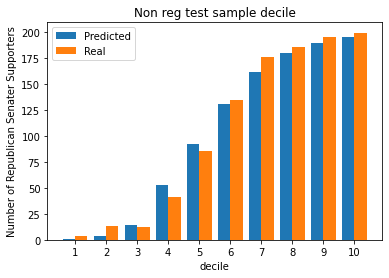

In [ ]:
import matplotlib.pyplot as plt 
X_p = [1,2,3,4,5,6,7,8,9,10]
X_axis = np.arange(len(X_p))
plt.bar(X_axis - 0.2, P, 0.4, label = 'Predicted')
plt.bar(X_axis + 0.2, R, 0.4, label = 'Real')
plt.xticks(X_axis, X_p)
plt.xlabel("decile")
plt.ylabel("Number of Republican Senater Supporters")
plt.title("Non reg test sample decile")

plt.legend()
plt.savefig('decile_test_sample.png')

# Full Sample Validation

Generating Predicted and true probability based on the best sample size (2000)

In [ ]:
result = deepcopy(full_sample)

result['age'] = result.filter(regex = 'age').idxmax(axis = 1)
result['ethnicity'] = result[['black', 'hispanic', 'asian','other_ethnicity']].idxmax(axis = 1)
#result['party'] = result[['dem_primary_voter', 'rep_primary_voter']].idxmax(axis = 1)
result['income'] = result[['Income 030k-50k', 'Income 050k-75k', 'Income 075k-125k', 'Income 125k+']].idxmax(axis = 1)
result['education'] = result[['bach_degree_modeled', 'post_grad_modeled']].idxmax(axis = 1)
result['urbanicity'] = result[['dRural','cOuter Ring', 'bInner Ring']].idxmax(axis = 1)

In [ ]:
validation_vars = ['age', 'retired', 'gender_male', 'ethnicity', 'income', 'education', 'urbanicity', #'party',
                   #'midterm_voter', 'new_registrant', 'non_voter', 'presidential_voter','dem_primary_mr',
                   'rep_primary_mr',
                   'absentee_voter', 'early_voter', 'single']

In [ ]:
true_probs = []
for var in validation_vars:
    pp_group = result.groupby(var)['support_gov'].mean()
    true_probs += pp_group.tolist()

In [ ]:
predicted_probs = []
for var in validation_vars:
    pp_group = result.groupby(var)['predicted_probability'].mean()
    predicted_probs += pp_group.tolist()

In [ ]:
validation_categories = []
for l in [list(result[var].value_counts().index) for var in validation_vars]:
  validation_categories += l

In [ ]:
counts = []
for l in [list(result[var].value_counts()) for var in validation_vars]:
  counts += l

In [ ]:
from itertools import repeat

validation_vars_haha = []
for var in validation_vars:
  times_to_append = len(result[var].value_counts())
  validation_vars_haha.extend(repeat(var, times_to_append))

In [ ]:
validation_result = pd.DataFrame({'Variable': validation_vars_haha,
                                  'Category': validation_categories,
                                  'n_size': counts,
                                  'avg_true_support': true_probs,
                                  'avg_predicted_support': predicted_probs})

In [ ]:
topline = pd.DataFrame({'Variable': 'Topline',
                        'Category': 'Topline',
                        'n_size': len(result),
                        'avg_true_support': result['support_gov'].mean(),
                        'avg_predicted_support': result['predicted_probability'].mean()},
                        index =[0])

validation_result = pd.concat([topline, validation_result[:]]).reset_index(drop = True)

In [ ]:
interaction = pd.DataFrame({'Variable': ["single * gender_male"]*len(result[['single', 'gender_male']].value_counts()),
               'Category': [str(i[0]) + " * " + str(i[1]) for i in list(result[['single', 'gender_male']].value_counts().index)],
               'n_size': list(result[['single', 'gender_male']].value_counts()),
               'avg_true_support': list(result.groupby(['single', 'gender_male'])['support_gov'].mean()),
               'avg_predicted_support': list(result.groupby(['single', 'gender_male'])['predicted_probability'].mean())})

validation_result = pd.concat([validation_result, interaction], axis = 0)

In [ ]:
validation_result['diff'] = validation_result['avg_predicted_support'] - validation_result['avg_true_support']
validation_result 

,Variable,Category,n_size,avg_true_support,avg_predicted_support,diff
0,Topline,Topline,8019,0.520140,0.516199,-0.003941
1,age,age_e60to69,1968,0.606272,0.600407,-0.005865
2,age,age_d50to59,1610,0.589953,0.590489,0.000535
3,age,age_f70to79,1571,0.581948,0.566676,-0.015272
4,age,age_c40to49,1263,0.491925,0.488579,-0.003347
5,age,age_b30to39,856,0.491362,0.484092,-0.007270
6,age,age_g80plus,464,0.499045,0.505932,0.006887
7,age,age_a22to29,287,0.461207,0.456441,-0.004765
8,retired,0.0,7821,0.521161,0.516779,-0.004382
9,retired,1.0,198,0.479798,0.493300,0.013502


In [ ]:
validation_result.to_csv("validation_result_full_sample.csv")

# Full Sample Decile

In [ ]:
hey = result[['support_gov','predicted_probability']].sort_values('predicted_probability')

In [ ]:
dfs=np.array_split(hey, 10)
P=[]
R=[]
for i in dfs:
  p=i["predicted_probability"].sum()
  r=i["support_gov"].sum()
  P.append(p)
  R.append(r)
print(P)
print(R)

[5.0101041623334455, 14.30084148226814, 64.37763329493771, 221.66471483863933, 382.2777981080345, 534.8531232174042, 656.6496788695842, 722.295303022511, 757.8173510776573, 780.1539620557355]
[22.0, 48.0, 38.0, 172.0, 360.0, 546.0, 682.0, 750.0, 766.0, 787.0]


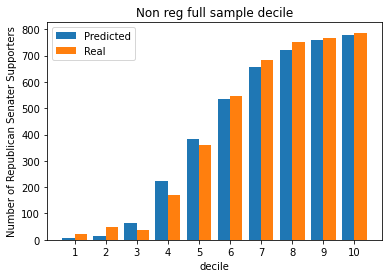

In [ ]:
import matplotlib.pyplot as plt 
X_p = [1,2,3,4,5,6,7,8,9,10]
X_axis = np.arange(len(X_p))
plt.bar(X_axis - 0.2, P, 0.4, label = 'Predicted')
plt.bar(X_axis + 0.2, R, 0.4, label = 'Real')
plt.xticks(X_axis, X_p)
plt.xlabel("decile")
plt.ylabel("Number of Republican Senater Supporters")
plt.title("Non reg full sample decile")

plt.legend()
plt.savefig('decile_full_sample.png')

# Monte Carlo Simulation

In [ ]:
full_sample = deepcopy(df[selected_vars])

sample_size_list = list(np.arange(100, len(full_sample), 100))
random_state_list = range(1,101)
sample_list_of_lists = []
for size in sample_size_list:
  sample_list = []
  for n in random_state_list:
    sample = full_sample.sample(n = size, random_state = n)
    sample_list.append(sample)
  sample_list_of_lists.append(sample_list)

In [ ]:
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
filterwarnings('ignore')

score_list_of_lists = []
cv_score = []
for sample_list in sample_list_of_lists:
  score_list = []
  cv_score_in = []
  for sample in sample_list:
    X = sample.drop(['support_gov'], axis=1)
    y = sample['support_gov']
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)
    logreg = LogisticRegression(random_state = 42).fit(X_train, y_train)
    scores = np.mean(cross_val_score(logreg, X_train, y_train, cv = cv, scoring = 'roc_auc')) #cv score
    cv_score_in.append(scores)
    score = roc_auc_score(y_test, logreg.predict_proba(X_test)[:, 1], average = 'weighted')# predict score <- use this to rank
    score_list.append(score)
  score_list_of_lists.append(score_list)
  cv_score.append(cv_score_in)

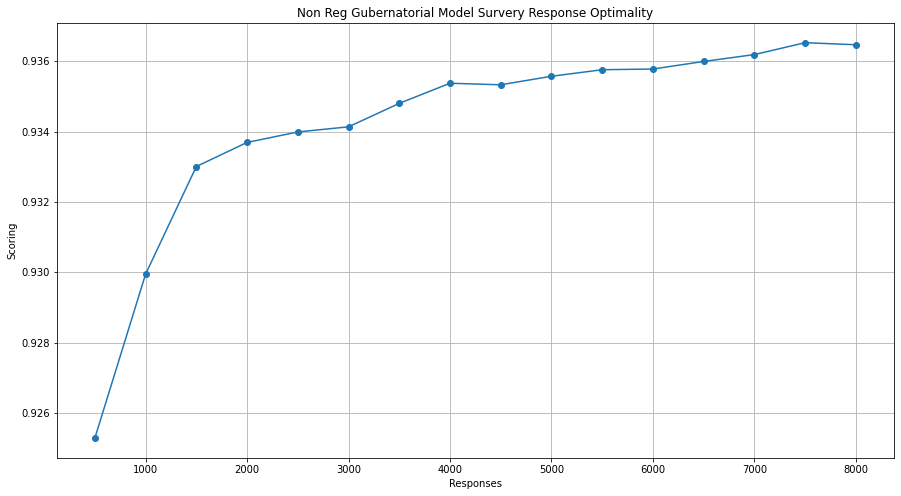

In [ ]:
mean_score_list = [np.mean(scores) for scores in score_list_of_lists]
mean_cv_score_list = [np.mean(scores) for scores in cv_score]

plt.figure(figsize = (15,8))
#plt.ylim((0.86,0.905))
plt.plot(sample_size_list, mean_cv_score_list, marker = 'o') #mean_score_list or mean_cv_score_list 
plt.title("Non Reg Gubernatorial Model Survery Response Optimality")
plt.ylabel('Scoring')
plt.xlabel('Responses')
plt.grid(True)

plt.savefig('monte_carlo.png')

Hence, we choose to use sample size 2000 as our final sample size.

In [ ]:
# Run 100 samples of size 2000 (choose the sample with the highest predicted results)
samples = []

for n in range(1, 101):
  sample = full_sample.sample(n = 2000, random_state = n)
  samples.append(sample)

score_list = []
for sample in samples:
  X = sample.drop(['support_gov'], axis=1)
  y = sample['support_gov']
  X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)
  logreg = LogisticRegression(random_state = 42).fit(X_train, y_train)
  scores = np.mean(cross_val_score(logreg, X_train, y_train, cv = cv, scoring = 'roc_auc')) #cv score
  score_list.append(scores)


In [ ]:
#choose the sample with the greatest cv_score
result = pd.DataFrame(
    {'Index': range(1, 101),
     'cv_score': score_list
    }).sort_values(by='cv_score',ascending=False)
print(result.head(3))
final_df = samples[5]